In [1]:
%load_ext google.cloud.bigquery

In [2]:
import numpy as np 
import pandas as pd
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/shuang/Downloads/bqair-2b59936a9500.json"

# Big query helpers
from google.cloud import bigquery
from bq_helper import BigQueryHelper

# Import plotting libaries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.io as pio
import geopandas
import shapely

# the Plotly in offline mode we can see map in the notebook.
from plotly.offline import download_plotlyjs,init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)

In [26]:
#getting CO daily summary data first:
QUERY = """
    SELECT
        state_code,
        county_code,
        date_local,
        arithmetic_mean,
        state_name,
        county_name,
        aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
      poc = 1
      AND EXTRACT(YEAR FROM date_local) in (2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017)
    
        """

In [27]:
bq_assistant = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")

In [28]:
df_co = bq_assistant.query_to_pandas(QUERY) # getting data through big query to pandas

In [29]:
df_co.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi
0,02,020,2009-01-23,0.400000,Alaska,Anchorage,NaN
1,02,020,2010-11-06,0.562500,Alaska,Anchorage,NaN
2,48,245,2007-07-16,0.237500,Texas,Jefferson,3.0
3,48,309,2011-07-15,0.100000,Texas,McLennan,NaN
4,02,020,2011-12-28,0.354167,Alaska,Anchorage,NaN


In [30]:
df_co['date_local'] = pd.to_datetime(df_co['date_local'])
df_co['year'] = df_co['date_local'].dt.year
df_co['month'] = df_co['date_local'].dt.month
import calendar
df_co['month_name'] = df_co['month'].apply(lambda x: calendar.month_abbr[x])
df_co['aqi'].fillna(df_co['aqi'].mean(), inplace = True)
df_co.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name
0,02,020,2009-01-23,0.400000,Alaska,Anchorage,6.411328,2009,1,Jan
1,02,020,2010-11-06,0.562500,Alaska,Anchorage,6.411328,2010,11,Nov
2,48,245,2007-07-16,0.237500,Texas,Jefferson,3.000000,2007,7,Jul
3,48,309,2011-07-15,0.100000,Texas,McLennan,6.411328,2011,7,Jul
4,02,020,2011-12-28,0.354167,Alaska,Anchorage,6.411328,2011,12,Dec


In [31]:
df_co.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181940 entries, 0 to 81939
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 267.0+ MB


In [32]:
df_co.drop_duplicates()
df_co.info()   #means there is no duplicate rows, that's good.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3181940 entries, 0 to 81939
Data columns (total 10 columns):
state_code         object
county_code        object
date_local         datetime64[ns]
arithmetic_mean    float64
state_name         object
county_name        object
aqi                float64
year               int64
month              int64
month_name         object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 267.0+ MB


In [39]:
#make a new data frame of avg aqi value with each year.
df_co_avg = df_co.groupby('year')['aqi'].mean()
df_co_avg = df_co_avg.reset_index()
df_co_avg.head(10)

,year,aqi
0,2004,7.878685
1,2005,7.536522
2,2006,7.282775
3,2007,6.796480
4,2008,6.471870
5,2009,6.267285
6,2010,6.085429
7,2011,5.996953
8,2012,5.856599
9,2013,5.633861


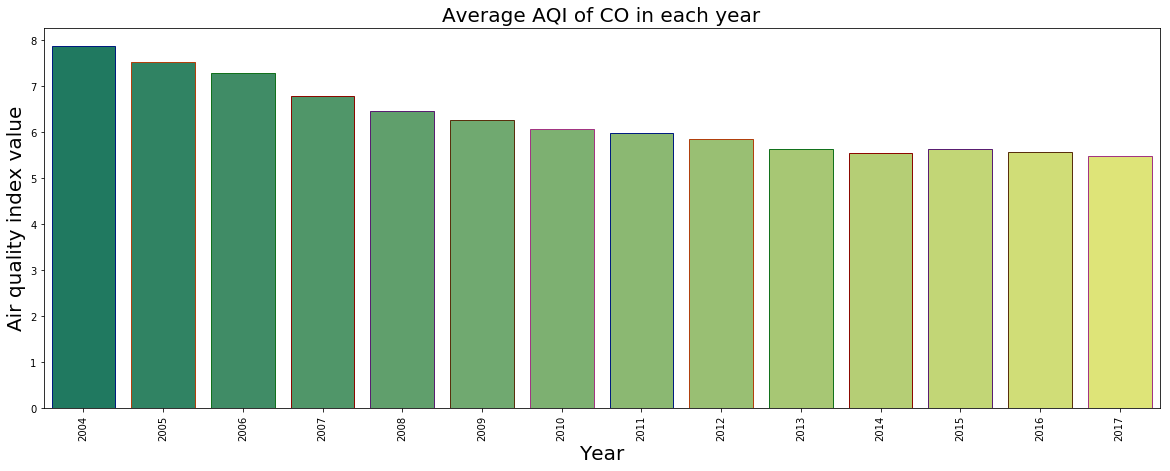

In [56]:
plt.subplots(figsize=(20,7))
sns.barplot(x='year',y='aqi',data=df_co_avg,palette='summer',edgecolor=sns.color_palette('dark',7))
plt.ylabel('Air quality index value', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Year', fontsize=20)
plt.title('Average AQI of CO in each year', fontsize=20)
plt.show()

In [57]:
def year_data(year):
    df = df_co[df_co.year == year ]
    df['aqi_mean_of_year'] = df.aqi.mean()
    return df

In [58]:
co_2011 = year_data(2011)
co_2011.head()

,state_code,county_code,date_local,arithmetic_mean,state_name,county_name,aqi,year,month,month_name,aqi_mean_of_year
3,48,309,2011-07-15,0.100000,Texas,McLennan,6.411328,2011,7,Jul,5.996953
4,02,020,2011-12-28,0.354167,Alaska,Anchorage,6.411328,2011,12,Dec,5.996953
20,42,043,2011-12-21,0.483333,Pennsylvania,Dauphin,7.000000,2011,12,Dec,5.996953
37,42,043,2011-12-21,0.487500,Pennsylvania,Dauphin,6.411328,2011,12,Dec,5.996953
42,48,309,2011-07-14,0.100000,Texas,McLennan,1.000000,2011,7,Jul,5.996953


In [59]:
co_2012 = year_data(2012)
co_2013 = year_data(2013)
co_2014 = year_data(2014)
co_2015 = year_data(2015)
co_2016 = year_data(2016)

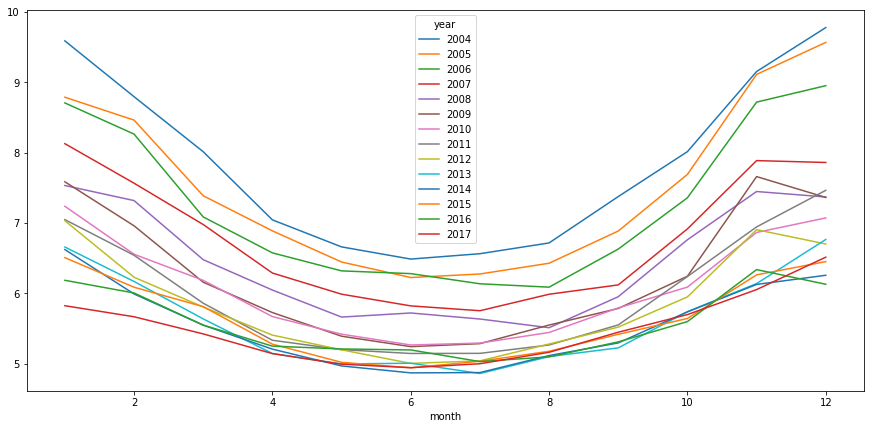

In [60]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m')

x = df_co.date_local
y1 = co_2011.aqi_mean_of_year
y2 = co_2012.aqi_mean_of_year
y3 = co_2013.aqi_mean_of_year
y4 = co_2014.aqi_mean_of_year
y5 = co_2015.aqi_mean_of_year
y6 = co_2016.aqi_mean_of_year

fig,ax = plt.subplots(figsize = (15,7))
df_co.groupby(['month','year']).mean()['aqi'].unstack().plot(ax=ax)
